# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
from dotenv import load_dotenv
import os

env_path = '../../data/.env'
load_dotenv(dotenv_path=env_path)

HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
today

datetime.datetime(2024, 11, 18, 20, 12, 42, 591301)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
project = hopsworks.login(project='AMomozZz')
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1163416
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry, Get Weather Forecast Features with Feature View</span>

In [4]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="aq_xgboost_model",
    version=1,
)
weather_fg = fs.get_feature_group(
    name='new_w',
    version=1,
)
air_quality_fg = fs.get_feature_group(
    name='new_aq',
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [5]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='9.53242E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float'...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [6]:
batch_data = weather_fg.filter(weather_fg.date >= today).read().sort_values(by=['date'], ascending=True, ignore_index=True).head(9)
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.82s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,pm25_4,...,pm25_11,pm25_12,pm25_13,pm25_14,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20
0,2024-11-19 00:00:00+00:00,12.30,0.0,6.489992,340.559875,shanghai,34.0,13.0,25.0,156.0,...,55.0,35.0,35.0,45.0,124.0,140.0,103.0,20.0,49.0,54.0
1,2024-11-20 00:00:00+00:00,12.50,0.0,6.569383,9.462261,shanghai,NaN,34.0,13.0,25.0,...,46.0,55.0,35.0,35.0,45.0,124.0,140.0,103.0,20.0,49.0
2,2024-11-21 00:00:00+00:00,12.30,0.0,5.804825,352.875061,shanghai,NaN,NaN,34.0,13.0,...,56.0,46.0,55.0,35.0,35.0,45.0,124.0,140.0,103.0,20.0
3,2024-11-22 00:00:00+00:00,12.65,0.0,9.449572,17.744766,shanghai,NaN,NaN,NaN,34.0,...,132.0,56.0,46.0,55.0,35.0,35.0,45.0,124.0,140.0,103.0
4,2024-11-23 00:00:00+00:00,12.10,0.0,6.369050,47.290634,shanghai,NaN,NaN,NaN,NaN,...,144.0,132.0,56.0,46.0,55.0,35.0,35.0,45.0,124.0,140.0
5,2024-11-24 00:00:00+00:00,13.90,0.0,7.895416,65.772263,shanghai,NaN,NaN,NaN,NaN,...,76.0,144.0,132.0,56.0,46.0,55.0,35.0,35.0,45.0,124.0
6,2024-11-25 00:00:00+00:00,13.75,0.3,11.631956,291.801483,shanghai,NaN,NaN,NaN,NaN,...,68.0,76.0,144.0,132.0,56.0,46.0,55.0,35.0,35.0,45.0
7,2024-11-26 00:00:00+00:00,6.80,0.0,10.538843,277.853210,shanghai,NaN,NaN,NaN,NaN,...,156.0,68.0,76.0,144.0,132.0,56.0,46.0,55.0,35.0,35.0
8,2024-11-27 00:00:00+00:00,6.10,0.0,5.495161,301.607452,shanghai,NaN,NaN,NaN,NaN,...,25.0,156.0,68.0,76.0,144.0,132.0,56.0,46.0,55.0,35.0


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [7]:
# batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#     batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', "pm25_yesterday"]])

l = []
for i in weather_fg.features:
    if i.name != 'date' and i.name != 'city':
        l.append(i.name)

batch_data['predicted_pm25'] = None

for i in range(0, len(batch_data)):
    p = retrieved_xgboost_model.predict(batch_data.iloc[[i]][l])[0]
    batch_data.at[i, 'predicted_pm25'] = p
    index = 1
    for j in range(i+1, batch_data.shape[0]):
        batch_data.at[j, f"pm25_{index}"] = p
        index += 1

display(batch_data)
batch_data.info()

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,pm25_4,...,pm25_12,pm25_13,pm25_14,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20,predicted_pm25
0,2024-11-19 00:00:00+00:00,12.30,0.0,6.489992,340.559875,shanghai,34.000000,13.000000,25.000000,156.000000,...,35.0,35.0,45.0,124.0,140.0,103.0,20.0,49.0,54.0,100.41008
1,2024-11-20 00:00:00+00:00,12.50,0.0,6.569383,9.462261,shanghai,100.410080,34.000000,13.000000,25.000000,...,55.0,35.0,35.0,45.0,124.0,140.0,103.0,20.0,49.0,120.970528
2,2024-11-21 00:00:00+00:00,12.30,0.0,5.804825,352.875061,shanghai,120.970528,100.410080,34.000000,13.000000,...,46.0,55.0,35.0,35.0,45.0,124.0,140.0,103.0,20.0,123.054131
3,2024-11-22 00:00:00+00:00,12.65,0.0,9.449572,17.744766,shanghai,123.054131,120.970528,100.410080,34.000000,...,56.0,46.0,55.0,35.0,35.0,45.0,124.0,140.0,103.0,141.677536
4,2024-11-23 00:00:00+00:00,12.10,0.0,6.369050,47.290634,shanghai,141.677536,123.054131,120.970528,100.410080,...,132.0,56.0,46.0,55.0,35.0,35.0,45.0,124.0,140.0,122.389397
5,2024-11-24 00:00:00+00:00,13.90,0.0,7.895416,65.772263,shanghai,122.389397,141.677536,123.054131,120.970528,...,144.0,132.0,56.0,46.0,55.0,35.0,35.0,45.0,124.0,115.165916
6,2024-11-25 00:00:00+00:00,13.75,0.3,11.631956,291.801483,shanghai,115.165916,122.389397,141.677536,123.054131,...,76.0,144.0,132.0,56.0,46.0,55.0,35.0,35.0,45.0,112.679176
7,2024-11-26 00:00:00+00:00,6.80,0.0,10.538843,277.853210,shanghai,112.679176,115.165916,122.389397,141.677536,...,68.0,76.0,144.0,132.0,56.0,46.0,55.0,35.0,35.0,127.881462
8,2024-11-27 00:00:00+00:00,6.10,0.0,5.495161,301.607452,shanghai,127.881462,112.679176,115.165916,122.389397,...,156.0,68.0,76.0,144.0,132.0,56.0,46.0,55.0,35.0,124.704399


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_1                       9 non-null      float32            
 7   pm25_2                       9 non-null      float32            
 8   pm25_3                       9 non-null      float32            
 9   pm25_4                       9 non-null      float32            
 10  pm25_5                       9 non-null      float32  

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [8]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
# batch_data = batch_data.sort_values(by=['date'])
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
display(batch_data)
batch_data.info()

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,pm25_4,...,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-19 00:00:00+00:00,12.30,0.0,6.489992,340.559875,shanghai,34.000000,13.000000,25.000000,156.000000,...,124.0,140.0,103.0,20.0,49.0,54.0,100.41008,jinganjiancezhan,china,1
1,2024-11-20 00:00:00+00:00,12.50,0.0,6.569383,9.462261,shanghai,100.410080,34.000000,13.000000,25.000000,...,45.0,124.0,140.0,103.0,20.0,49.0,120.970528,jinganjiancezhan,china,2
2,2024-11-21 00:00:00+00:00,12.30,0.0,5.804825,352.875061,shanghai,120.970528,100.410080,34.000000,13.000000,...,35.0,45.0,124.0,140.0,103.0,20.0,123.054131,jinganjiancezhan,china,3
3,2024-11-22 00:00:00+00:00,12.65,0.0,9.449572,17.744766,shanghai,123.054131,120.970528,100.410080,34.000000,...,35.0,35.0,45.0,124.0,140.0,103.0,141.677536,jinganjiancezhan,china,4
4,2024-11-23 00:00:00+00:00,12.10,0.0,6.369050,47.290634,shanghai,141.677536,123.054131,120.970528,100.410080,...,55.0,35.0,35.0,45.0,124.0,140.0,122.389397,jinganjiancezhan,china,5
5,2024-11-24 00:00:00+00:00,13.90,0.0,7.895416,65.772263,shanghai,122.389397,141.677536,123.054131,120.970528,...,46.0,55.0,35.0,35.0,45.0,124.0,115.165916,jinganjiancezhan,china,6
6,2024-11-25 00:00:00+00:00,13.75,0.3,11.631956,291.801483,shanghai,115.165916,122.389397,141.677536,123.054131,...,56.0,46.0,55.0,35.0,35.0,45.0,112.679176,jinganjiancezhan,china,7
7,2024-11-26 00:00:00+00:00,6.80,0.0,10.538843,277.853210,shanghai,112.679176,115.165916,122.389397,141.677536,...,132.0,56.0,46.0,55.0,35.0,35.0,127.881462,jinganjiancezhan,china,8
8,2024-11-27 00:00:00+00:00,6.10,0.0,5.495161,301.607452,shanghai,127.881462,112.679176,115.165916,122.389397,...,144.0,132.0,56.0,46.0,55.0,35.0,124.704399,jinganjiancezhan,china,9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_1                       9 non-null      float32            
 7   pm25_2                       9 non-null      float32            
 8   pm25_3                       9 non-null      float32            
 9   pm25_4                       9 non-null      float32            
 10  pm25_5                       9 non-null      float32  

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-18 19:25:49,810 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



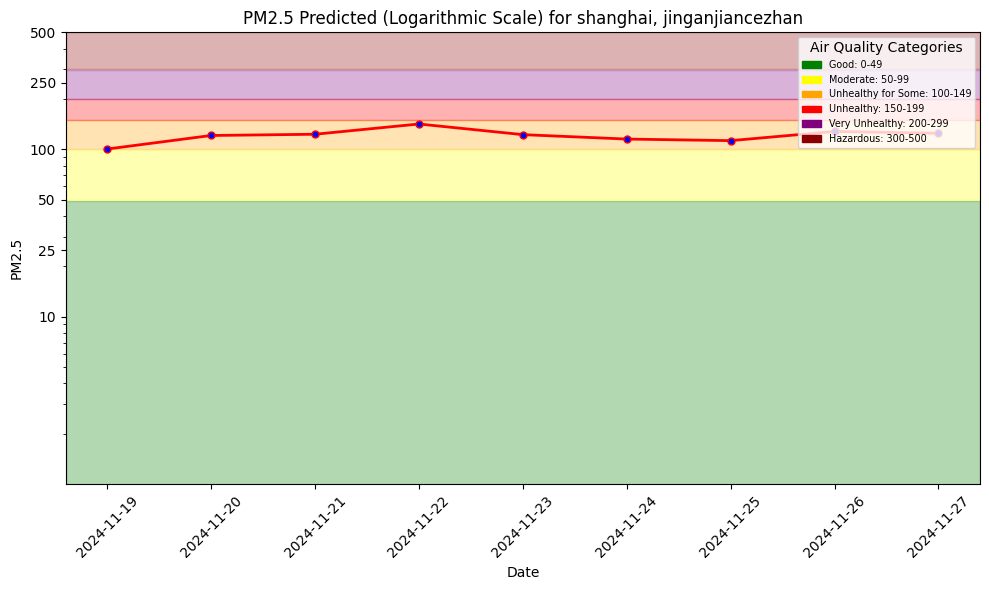

In [9]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [5]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=3,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [11]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1163416/jobs/named/aq_predictions_3_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x258d07c8610>, None)

In [6]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.77s) 


In [7]:
display(monitor_fg.read().sort_values(by=['date'], ascending=True))
display(monitoring_df)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.20s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,pm25_4,...,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20,predicted_pm25,street,country,days_before_forecast_day
9,2024-11-12 00:00:00+00:00,16.750000,0.0,7.145796,49.085716,shanghai,132.000000,56.000000,46.000000,55.000000,...,115.0,34.0,23.0,47.0,46.0,95.0,108.817917,jinganjiancezhan,china,1
5,2024-11-13 00:00:00+00:00,17.400000,0.0,7.862518,105.945465,shanghai,144.000000,132.000000,56.000000,46.000000,...,49.0,115.0,34.0,23.0,47.0,46.0,147.276321,jinganjiancezhan,china,1
12,2024-11-14 00:00:00+00:00,20.049999,0.4,7.895416,136.847595,shanghai,76.000000,144.000000,132.000000,56.000000,...,54.0,49.0,115.0,34.0,23.0,47.0,61.925117,jinganjiancezhan,china,1
3,2024-11-14 00:00:00+00:00,20.500000,0.0,7.421590,129.093857,shanghai,147.276321,144.000000,132.000000,56.000000,...,54.0,49.0,115.0,34.0,23.0,47.0,114.631012,jinganjiancezhan,china,2
0,2024-11-15 00:00:00+00:00,20.299999,0.1,7.771331,103.392517,shanghai,114.631012,147.276321,144.000000,132.000000,...,49.0,54.0,49.0,115.0,34.0,23.0,107.263954,jinganjiancezhan,china,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,2024-11-25 00:00:00+00:00,13.750000,0.3,11.631956,291.801483,shanghai,100.663673,123.653259,143.536026,114.301399,...,56.0,46.0,55.0,35.0,35.0,45.0,125.383339,jinganjiancezhan,china,9
60,2024-11-25 00:00:00+00:00,13.750000,0.3,11.631956,291.801483,shanghai,115.165916,122.389397,141.677536,123.054131,...,56.0,46.0,55.0,35.0,35.0,45.0,112.679176,jinganjiancezhan,china,7
56,2024-11-26 00:00:00+00:00,6.800000,0.0,10.538843,277.853210,shanghai,112.679176,115.165916,122.389397,141.677536,...,132.0,56.0,46.0,55.0,35.0,35.0,127.881462,jinganjiancezhan,china,8
47,2024-11-26 00:00:00+00:00,6.800000,0.0,10.538843,277.853210,shanghai,125.383339,100.663673,123.653259,143.536026,...,132.0,56.0,46.0,55.0,35.0,35.0,119.578758,jinganjiancezhan,china,9


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1,pm25_2,pm25_3,pm25_4,...,pm25_15,pm25_16,pm25_17,pm25_18,pm25_19,pm25_20,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-13 00:00:00+00:00,17.400000,0.0,7.862518,105.945465,shanghai,144.0,132.0,56.0,46.0,...,49.0,115.0,34.0,23.0,47.0,46.0,147.276321,jinganjiancezhan,china,1
1,2024-11-12 00:00:00+00:00,16.750000,0.0,7.145796,49.085716,shanghai,132.0,56.0,46.0,55.0,...,115.0,34.0,23.0,47.0,46.0,95.0,108.817917,jinganjiancezhan,china,1
2,2024-11-14 00:00:00+00:00,20.049999,0.4,7.895416,136.847595,shanghai,76.0,144.0,132.0,56.0,...,54.0,49.0,115.0,34.0,23.0,47.0,61.925117,jinganjiancezhan,china,1
3,2024-11-15 00:00:00+00:00,20.100000,0.0,6.924738,62.102829,shanghai,68.0,76.0,144.0,132.0,...,49.0,54.0,49.0,115.0,34.0,23.0,83.168175,jinganjiancezhan,china,1
4,2024-11-16 00:00:00+00:00,17.400000,0.0,10.661107,11.689341,shanghai,156.0,68.0,76.0,144.0,...,20.0,49.0,54.0,49.0,115.0,34.0,125.938301,jinganjiancezhan,china,1
5,2024-11-17 00:00:00+00:00,14.100000,0.0,14.458382,18.886187,shanghai,25.0,156.0,68.0,76.0,...,103.0,20.0,49.0,54.0,49.0,115.0,14.930276,jinganjiancezhan,china,1
6,2024-11-18 00:00:00+00:00,12.900000,0.0,11.885453,35.134277,shanghai,13.0,25.0,156.0,68.0,...,140.0,103.0,20.0,49.0,54.0,49.0,71.697426,jinganjiancezhan,china,1
7,2024-11-19 00:00:00+00:00,12.300000,0.0,6.489992,340.559875,shanghai,34.0,13.0,25.0,156.0,...,124.0,140.0,103.0,20.0,49.0,54.0,100.410080,jinganjiancezhan,china,1


In [8]:
air_quality_df = air_quality_fg.read()
air_quality_fg.read().sort_values(by=['date'], ascending=True).tail(5)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.29s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.99s) 


,date,pm25,country,city,street,url
3955,2024-11-14 00:00:00+00:00,68.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
3956,2024-11-15 00:00:00+00:00,156.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
3959,2024-11-16 00:00:00+00:00,25.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
3957,2024-11-17 00:00:00+00:00,13.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486
3958,2024-11-18 00:00:00+00:00,34.0,china,shanghai,jinganjiancezhan,https://api.waqi.info/feed/@486


In [9]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df = monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
1,2024-11-12 00:00:00+00:00,108.817917,144.0
0,2024-11-13 00:00:00+00:00,147.276321,76.0
2,2024-11-14 00:00:00+00:00,61.925117,68.0
3,2024-11-15 00:00:00+00:00,83.168175,156.0
4,2024-11-16 00:00:00+00:00,125.938301,25.0
5,2024-11-17 00:00:00+00:00,14.930276,13.0
6,2024-11-18 00:00:00+00:00,71.697426,34.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

2024-11-18 20:12:57,872 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



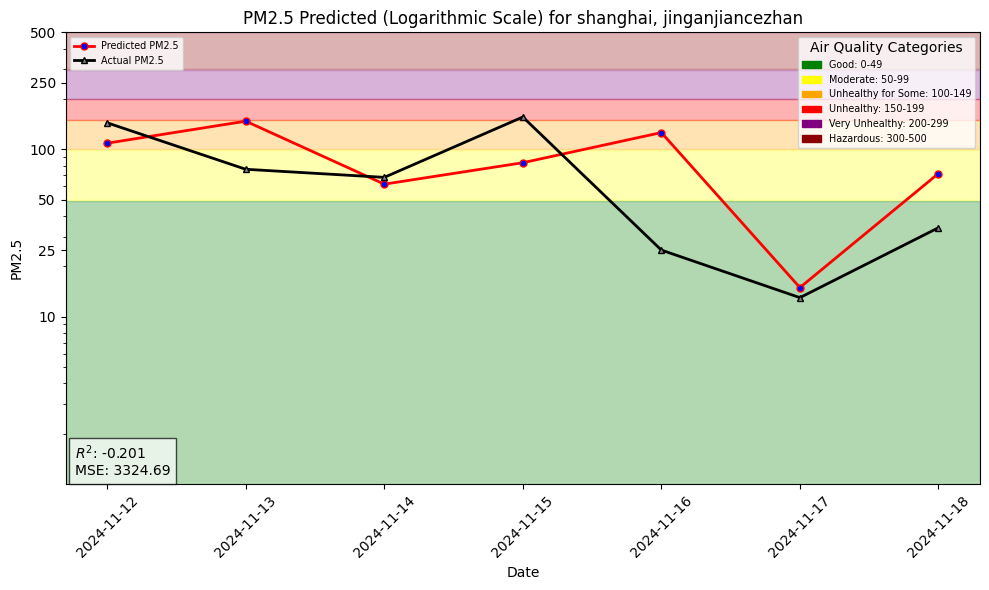

In [10]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()